In [4]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.6 MB/s eta 0:00:00


In [5]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

from datetime import datetime
from pandas_datareader.data import DataReader


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
# Load the news dataset
columns = ['Date', 'Category', 'News']
df_news= pd.read_csv("/content/drive/MyDrive/india-news-headlines.csv", names=columns)

In [12]:
df_news.head()

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [13]:
#Dropping the category columns
df_news.drop(0, inplace= True)
df_news.drop("Category", axis = 1, inplace = True)
df_news.head()

,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic


In [14]:
#loading the stock market dataset
dfs = pd.read_csv("/content/drive/MyDrive/^BSESN.csv")
dfs.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


In [17]:
#conversion of dataset to detection datatype
df_news["Date"] = pd.to_datetime(df_news["Date"], format = "%Y%m%d")
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 55.7+ MB


In [20]:
# Group the news headlines for each day
df_news ['News'] = df_news.groupby(['Date']).transform(lambda x:" ".join(x))
df_news = df_news.drop_duplicates()
df_news.reset_index(inplace=True,drop=True)

In [21]:
df_news.head()

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...


In [22]:
df_news.isnull().sum()

Date    0
News    0
dtype: int64

In [23]:
len(df_news)

7717

In [25]:
dfs = dfs[["Date", "Open", "High", "Low", "Close" , "Volume"]]
dfs.head()

,Date,Open,High,Low,Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0


In [26]:
#Check for common information of the stock dataset
dfs["Date"]= pd.to_datetime(dfs["Date"])
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.9 KB


In [27]:
dfs.describe()

,Open,High,Low,Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37804.237375,38071.182859,37422.826992,37745.454117,19134.000000
std,4507.985769,4380.974060,4647.212947,4535.304336,16540.261333
min,26499.810547,27462.869141,25638.900391,25981.240234,0.000000
25%,34369.659179,34779.932618,33975.389648,34257.097656,13125.000000
50%,38489.480469,38750.359375,38234.869140,38425.974610,17000.000000
75%,41179.222656,41376.482422,41023.923828,41135.233399,21075.000000
max,46774.320313,46992.570313,46627.601563,46890.339844,188300.000000


In [28]:
dfs.isnull().sum()

Date      0
Open      2
High      2
Low       2
Close     2
Volume    2
dtype: int64

In [29]:
dfs.dropna(inplace=True)

In [30]:
len(dfs)

250

Text(0, 0.5, 'BSESN')

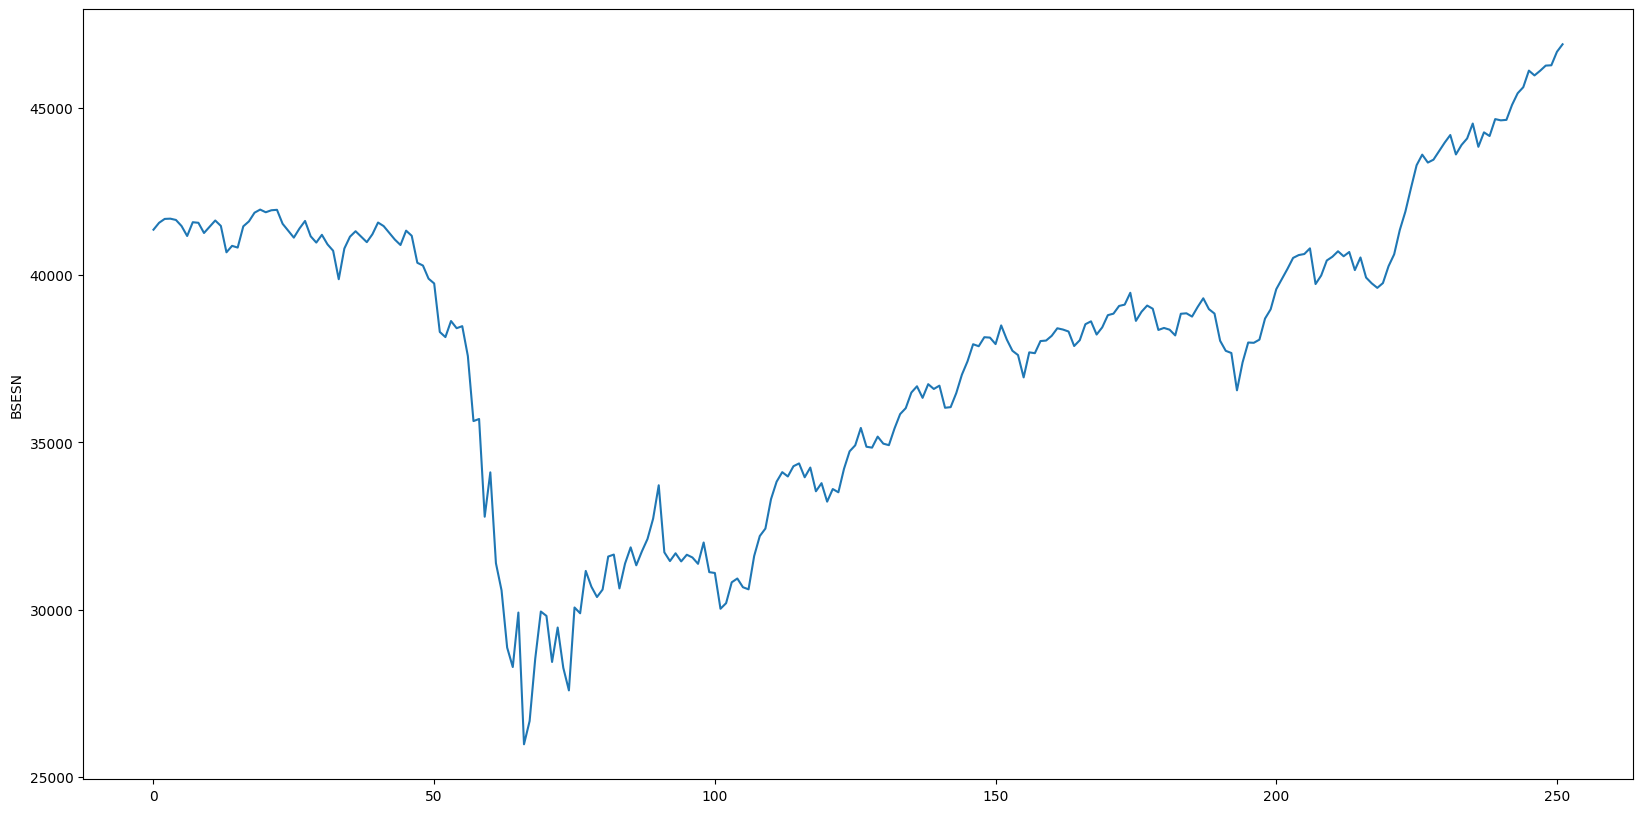

In [32]:
# Figure plot
plt.figure(figsize=(20,10))
dfs['Close'].plot()
plt.ylabel('BSESN')

In [33]:
#Removing the unwanted characters from the news headline
df_news.replace("[^a-zA-Z']"," ", regex=True, inplace = True)
df_news["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

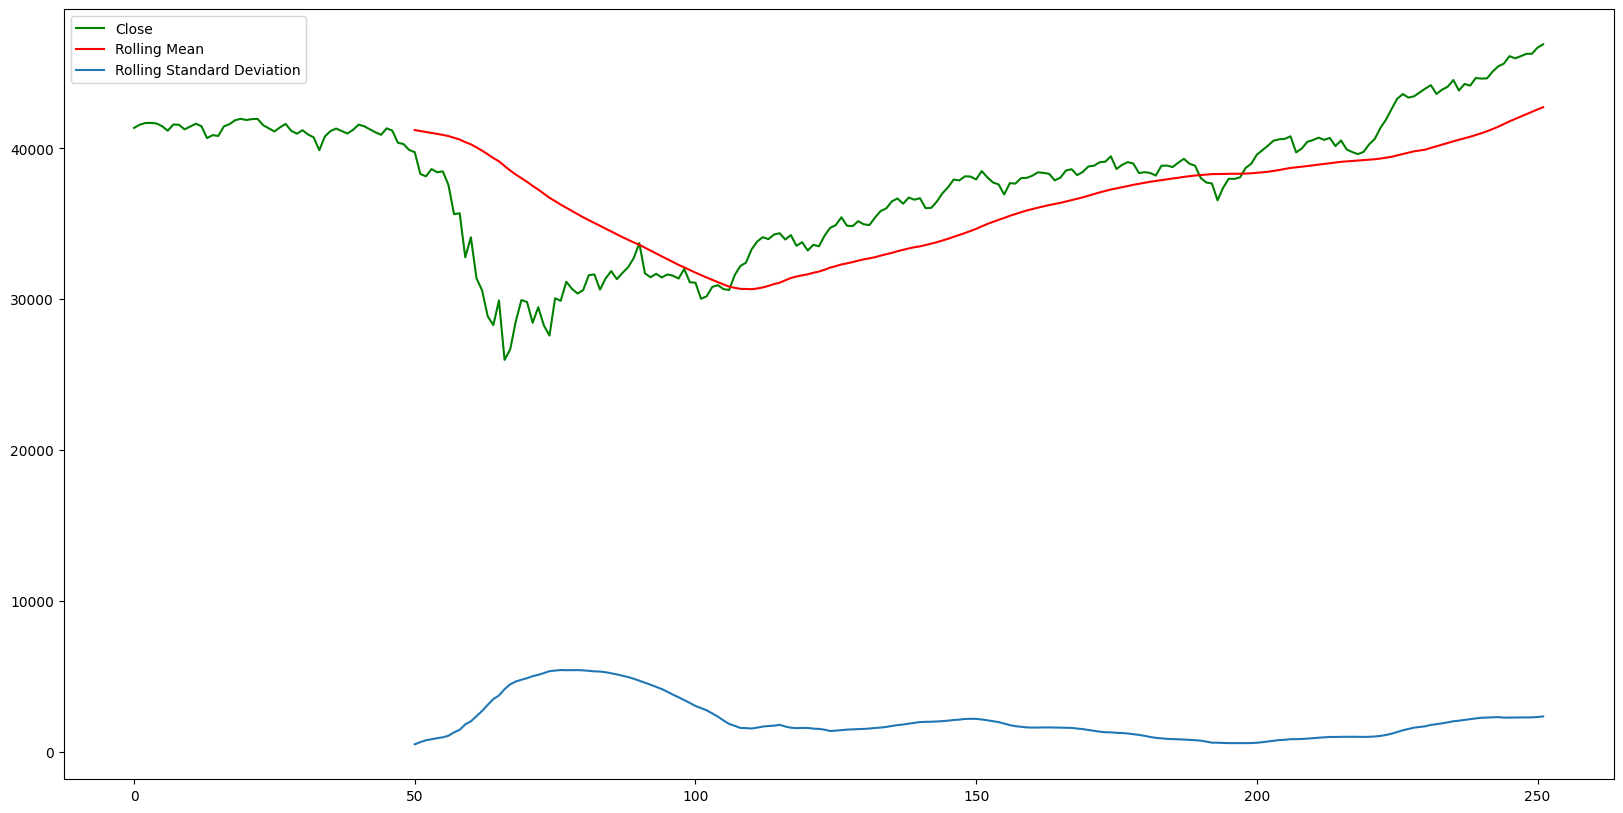

In [34]:
#Plotting moving average
close = dfs['Close']
ma = close.rolling (window = 50).mean()
std = close.rolling(window = 50).std()
plt.figure(figsize=(20,10))
dfs['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label = 'Rolling Mean')
std.plot(label='Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

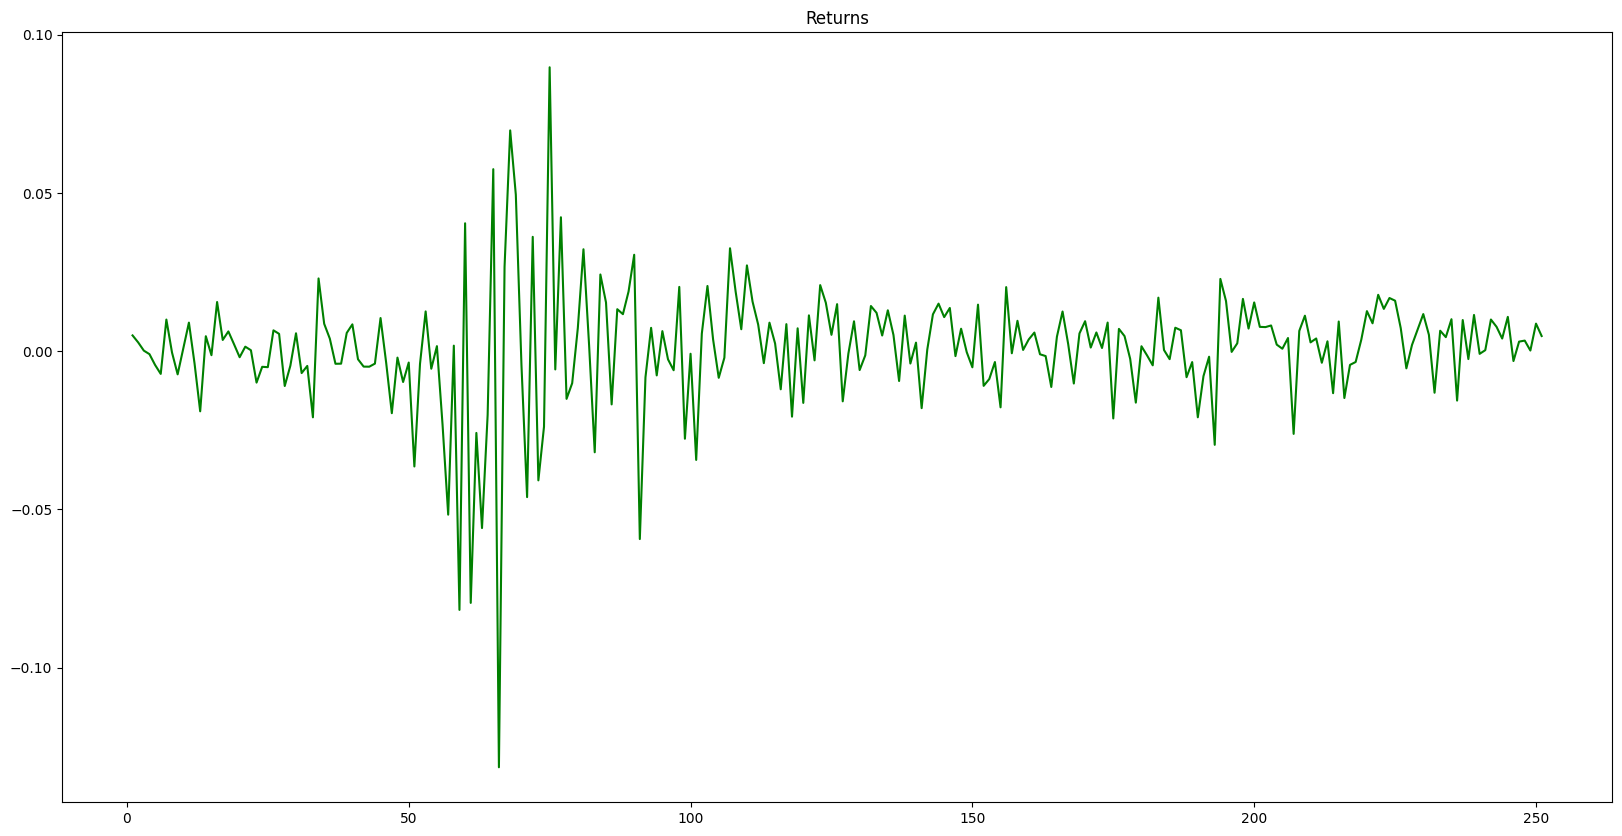

In [35]:
#Plotting the returns
returns = close/ close.shift(1) - 1

plt.figure(figsize= (20, 10))
returns.plot(label = 'Returns', color = 'g')
plt.title("Returns")

In [36]:
#Traqin Test Split
train = dfs[:126]
test = dfs[126:]

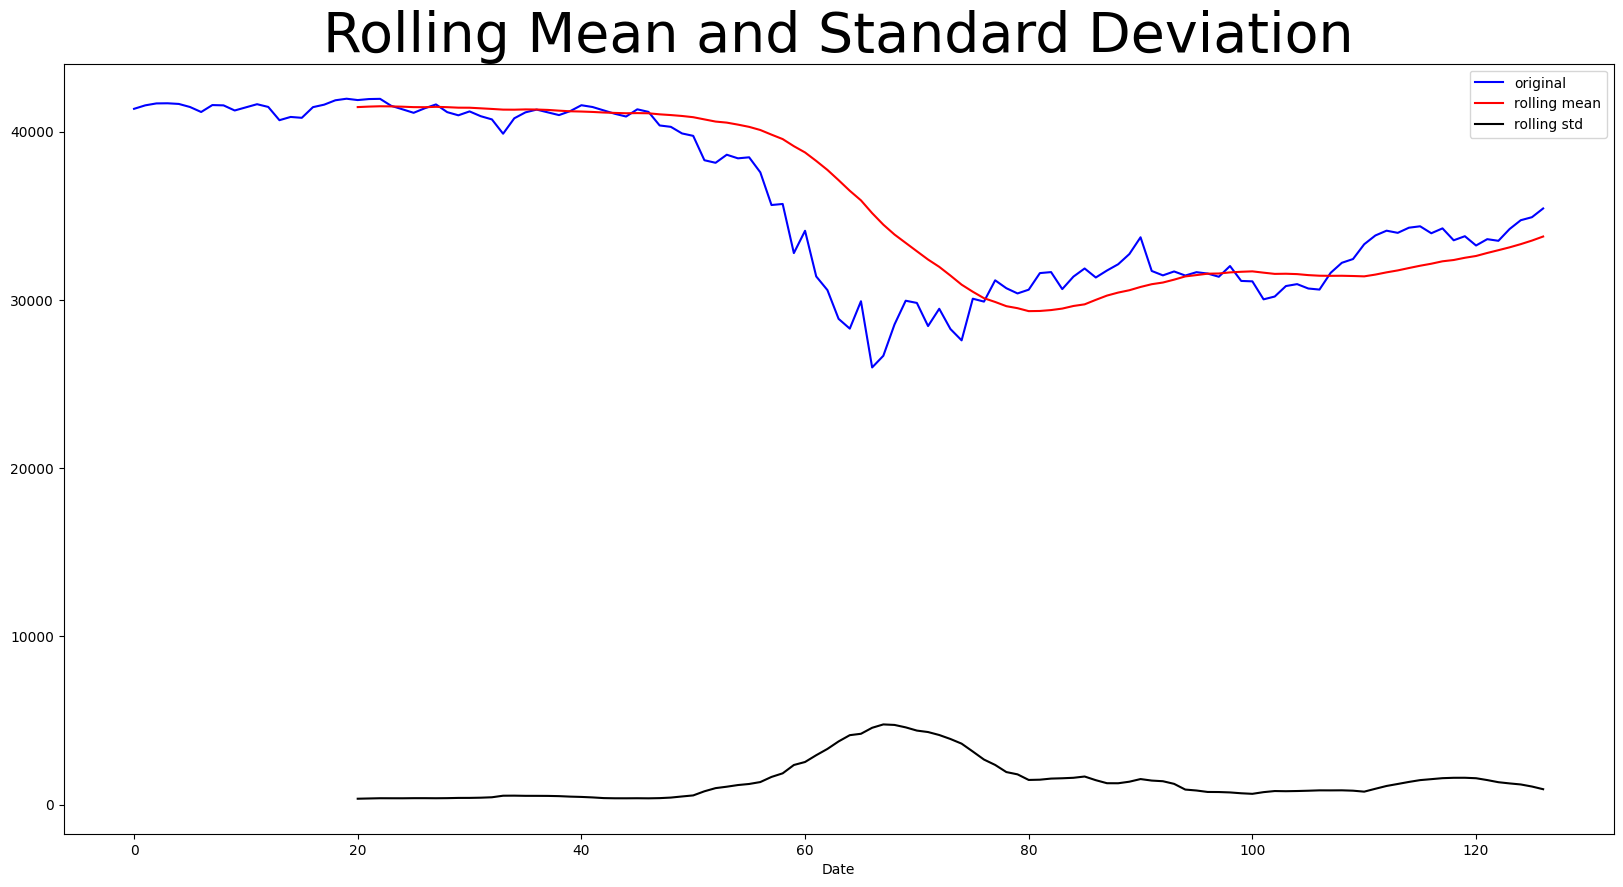

Results of dickey fuller test
ADF Test Statistic: -1.4258530903773337
p-value: 0.5698210001003252
Lags Used: 6
Number of Observations Used: 119
Weak evidence against null hypothesis, time series is non-stationary 


In [40]:
# Stationarity test
def test_stationarity (timeseries):
#Determine the rolling statistics
  rolmean =  timeseries.rolling (20).mean()
  rolstd = timeseries.rolling (20) .std()
 # Plot rolling statistics:
  plt.figure(figsize=(20, 10))
  plt.plot(timeseries, color='blue', label='original')
  plt.plot(rolmean, color='r', label='rolling mean')
  plt.plot (rolstd, color='black', label='rolling std')
  plt.xlabel('Date')
  plt.legend()
  plt.title('Rolling Mean and Standard Deviation', fontsize=40)
  plt.show(block=False)

  print('Results of dickey fuller test')
  result = adfuller (timeseries, autolag='AIC')
  labels = ['ADF Test Statistic', 'p-value','Lags Used', 'Number of Observations Used']

  for value, label in zip(result, labels):
    print (label+": " +str(value))
  if result[1] < 0.05:
    print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary")
  else:
    print("Weak evidence against null hypothesis, time series is non-stationary ")

test_stationarity(train['Close'])

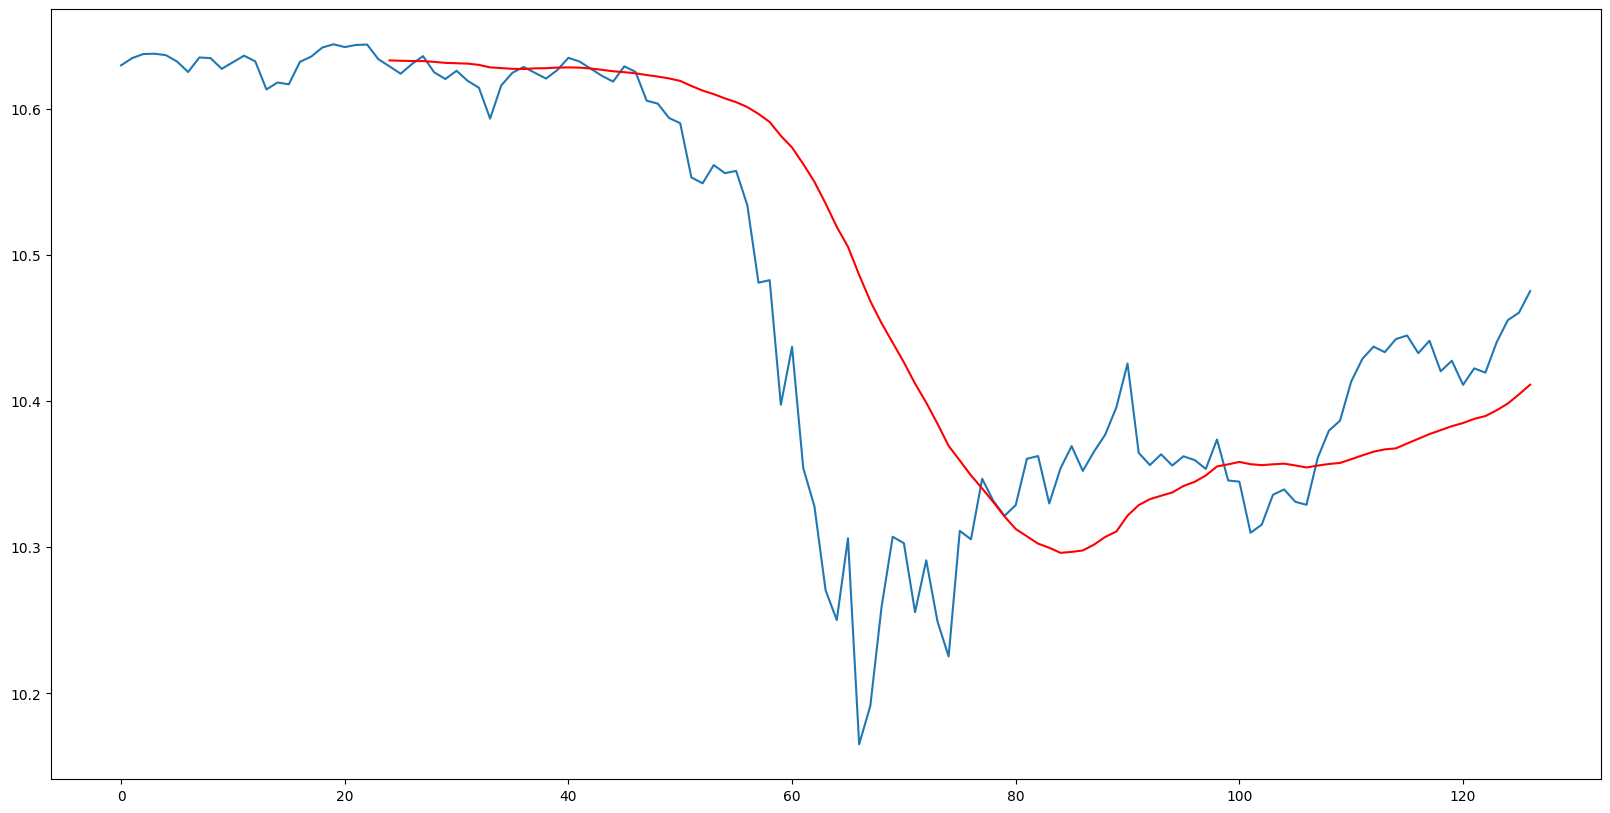

In [41]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])
mav = train_log.rolling(24).mean()
plt.figure(figsize = (20,10))
plt.plot(train_log)
plt.plot(mav, color = 'red')

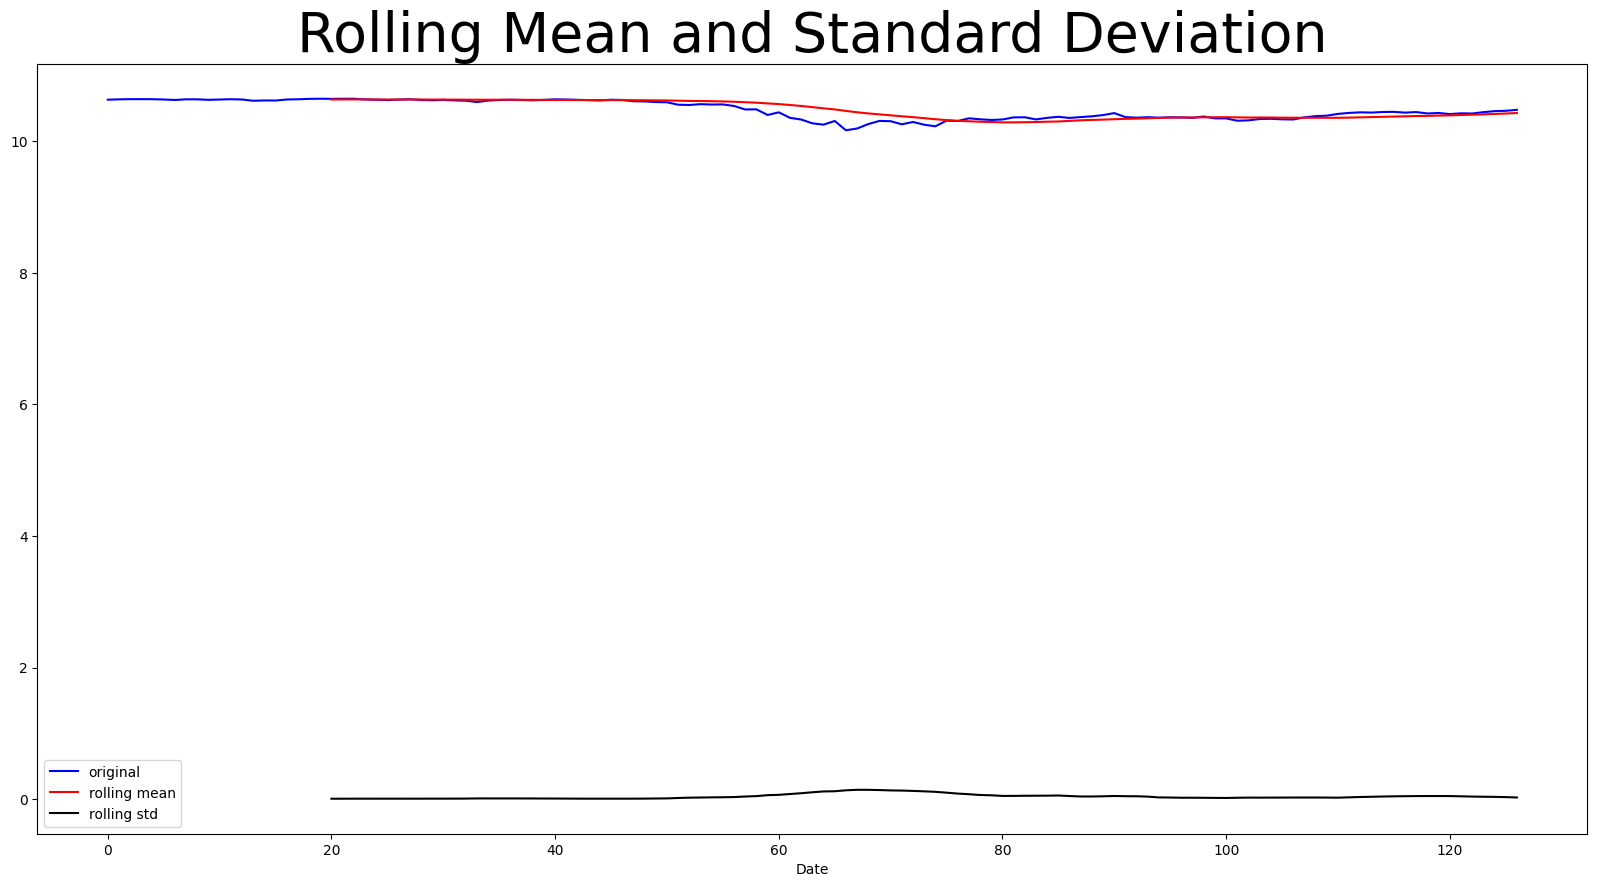

Results of dickey fuller test
ADF Test Statistic: -1.650075918406153
p-value: 0.4570008313543618
Lags Used: 7
Number of Observations Used: 118
Weak evidence against null hypothesis, time series is non-stationary 


In [42]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

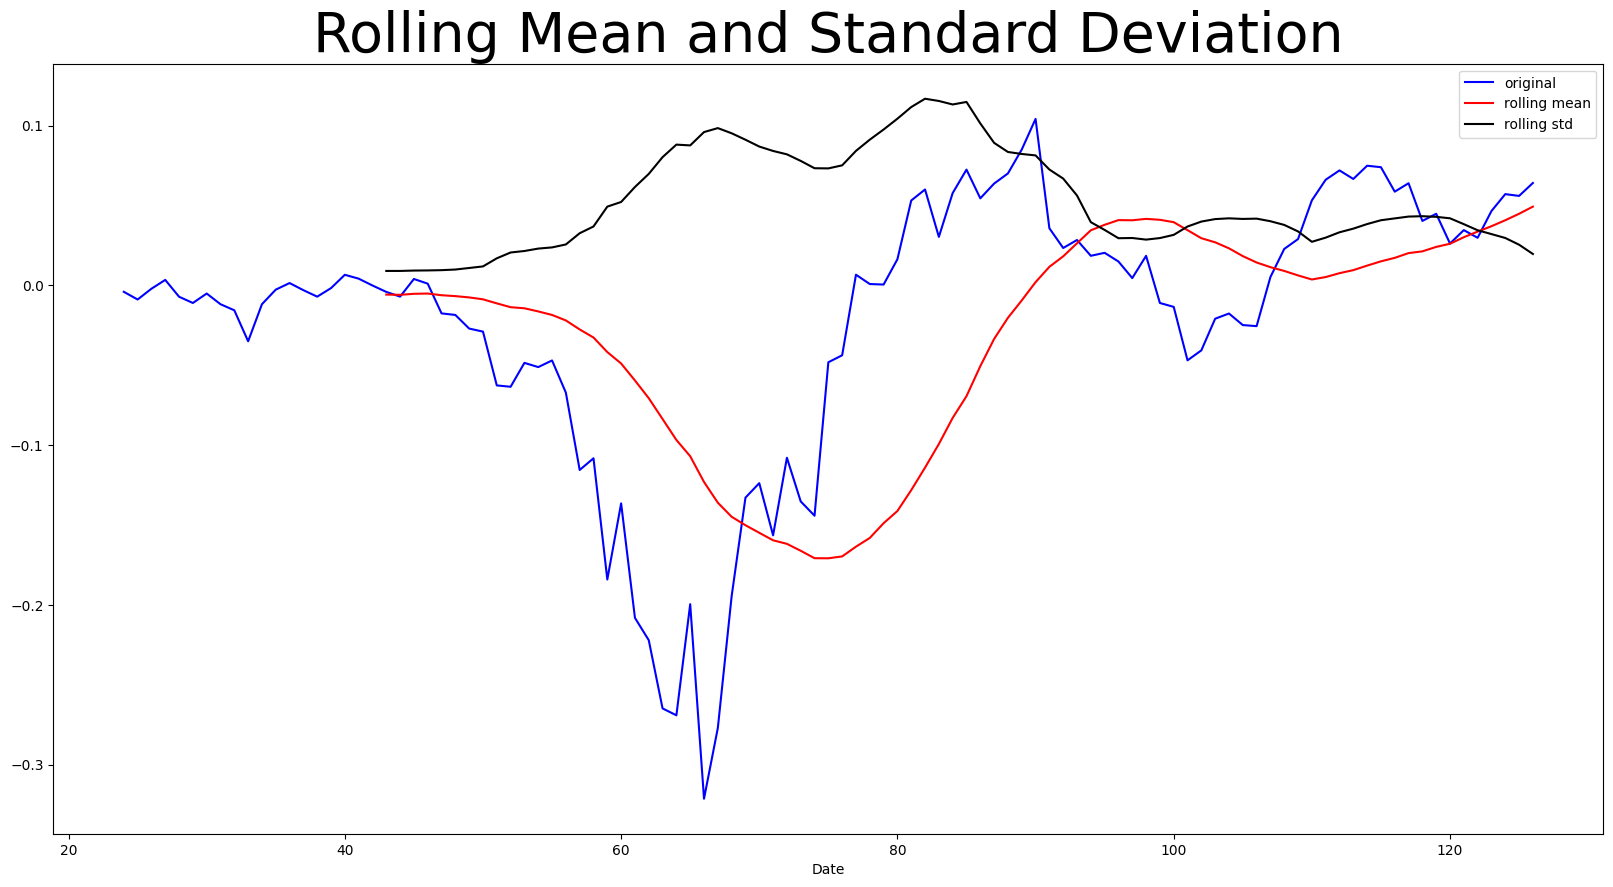

Results of dickey fuller test
ADF Test Statistic: -2.1839536124465124
p-value: 0.21212082977472757
Lags Used: 7
Number of Observations Used: 95
Weak evidence against null hypothesis, time series is non-stationary 


In [43]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [44]:
# Using AutoArima to make predictions in the log data
model = auto_arima (train_log, trace = True, error_action = "ignore", suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions - pd.DataFrame (predictions, index = test_log.index, columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-542.278, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-545.110, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-546.632, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-546.291, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-546.846, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-544.676, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.365 seconds


,Prediction,126,127,128,129,130,131,132,133,134,135
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Actual Stock Price')

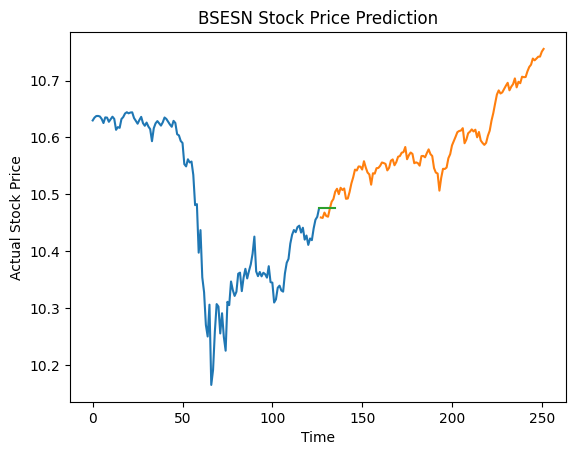

In [45]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [ ]:
#Textual analysis
#Functions to get the subjectivity and polarity
def getsubjectivity (text):
  return TextBlob(text).sentiment.subjectivity
def getPolarity (text):
  return TextBlob(text).sentiment.polarity

In [48]:
df_news[['Subjectivity', 'Polarity']] = df_news['News'].apply(lambda x: pd.Series([getsubjectivity(x), getPolarity(x)]))

In [50]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
#define a function to calculate sentiment scores for a given text
def get_sentiment_scores (text):
  scores = sia.polarity_scores (text)
  return scores['compound' ], scores['neg'], scores['neu'], scores ['pos']
#apply the function to each row of the DataFrame
df_news [['Compound', 'Negative', 'Neutral', 'Positive']]= df_news['News'].apply(lambda x: pd.Series(get_sentiment_scores(x)))

In [51]:
#Merging Historical and Textual Data
df_merge = pd.merge(dfs, df_news, how = 'inner', on = "Date")
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0,After Jagannath Temple Puri beach devpt plan ...,0.356256,0.037977,-1.0000,0.206,0.715,0.079
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0,What is Citizenship Amendment Bill All...,0.396291,0.039680,-0.9999,0.164,0.754,0.082
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0,Only of CCA covered after revamp of canals...,0.371783,0.029115,-0.9998,0.135,0.797,0.068
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0,I'm done playing the good girl I want to be a...,0.366210,0.047456,-0.9999,0.179,0.733,0.088
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0,Weekly Horoscope December Check predic...,0.393635,0.036077,-0.9999,0.157,0.753,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,26300.0,Ways to get you in the mood for sex when you'r...,0.374037,0.052291,-0.9999,0.168,0.743,0.089
246,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,18400.0,No threat from Covid claims to balance sheets ...,0.382335,0.072333,-0.9996,0.128,0.776,0.095
247,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,16400.0,RT PCR tests in a day only found ve ...,0.368751,0.039336,-0.9999,0.145,0.767,0.089
248,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,13100.0,Asmita Sood's favourite holiday destinations a...,0.427681,0.067088,-0.9997,0.124,0.793,0.083


In [53]:
dfmerge1 = df_merge[['Close', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,41352.171875,0.356256,0.037977,-1.0000,0.206,0.715,0.079
1,41558.570313,0.396291,0.039680,-0.9999,0.164,0.754,0.082
2,41673.921875,0.371783,0.029115,-0.9998,0.135,0.797,0.068
3,41681.539063,0.366210,0.047456,-0.9999,0.179,0.733,0.088
4,41642.660156,0.393635,0.036077,-0.9999,0.157,0.753,0.091
...,...,...,...,...,...,...,...
245,46099.011719,0.374037,0.052291,-0.9999,0.168,0.743,0.089
246,46253.460938,0.382335,0.072333,-0.9996,0.128,0.776,0.095
247,46263.171875,0.368751,0.039336,-0.9999,0.145,0.767,0.089
248,46666.460938,0.427681,0.067088,-0.9997,0.124,0.793,0.083


In [54]:
#NORMALIZE THE DATA
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()


,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.735131,0.157604,0.254831,0.00000,0.913386,0.044118,0.296296
1,0.745002,0.537627,0.270044,0.00005,0.582677,0.330882,0.333333
2,0.750519,0.304990,0.175669,0.00010,0.354331,0.647059,0.160494
3,0.750884,0.252084,0.339500,0.00005,0.700787,0.176471,0.407407
4,0.749024,0.512408,0.237860,0.00005,0.527559,0.323529,0.444444


In [55]:
X = df.drop('Close', axis = 1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.157604,0.254831,0.000000,0.913386,0.044118,0.296296
1,0.537627,0.270044,0.000050,0.582677,0.330882,0.333333
2,0.304990,0.175669,0.000100,0.354331,0.647059,0.160494
3,0.252084,0.339500,0.000050,0.700787,0.176471,0.407407
4,0.512408,0.237860,0.000050,0.527559,0.323529,0.444444
...,...,...,...,...,...,...
245,0.326385,0.382691,0.000050,0.614173,0.250000,0.419753
246,0.405146,0.561721,0.000201,0.299213,0.492647,0.493827
247,0.276208,0.266972,0.000050,0.433071,0.426471,0.419753
248,0.835584,0.514876,0.000151,0.267717,0.617647,0.345679


In [56]:
Y = df['Close']
Y

0      0.735131
1      0.745002
2      0.750519
3      0.750884
4      0.749024
         ...   
245    0.962154
246    0.969541
247    0.970005
248    0.989293
249    1.000000
Name: Close, Length: 250, dtype: float64

In [62]:
#Split the Dataset into Train and Test data
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
x_train.shape

(200, 6)

In [63]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
71,0.352071,0.288092,0.000100,0.401575,0.500000,0.333333
160,0.681128,0.572245,0.000050,0.417323,0.500000,0.308642
180,0.686480,0.370186,0.000050,0.535433,0.250000,0.543210
75,0.502568,0.748241,0.000151,0.322835,0.588235,0.308642
59,0.367044,0.196113,0.000000,0.850394,0.073529,0.345679
101,0.600065,0.456315,0.000100,0.322835,0.595588,0.296296
229,0.592298,0.326265,0.000050,0.559055,0.433824,0.197531
18,0.673951,0.602135,0.000000,0.692913,0.227941,0.333333
188,0.671094,0.314921,0.000100,0.251969,0.838235,0.000000
15,0.307918,0.606835,0.000050,0.496063,0.367647,0.407407


In [64]:
#Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)


In [65]:
print (prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction, y_test))

[0.42460327 0.48286573 0.55559627 0.62669084 0.41497149 0.40468188
 0.55420926 0.45768116 0.37217066 0.54278993]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
Mean Squared error:  0.03364936053653162


In [67]:
#Decision Tree Regressor
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)
print (predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.48163568 0.74050865 0.50758225 0.22520239 0.19541591 0.18965567
 0.58097472 0.35997158 0.25868307 0.84263412]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
Mean Squared error:  0.07109767982075108


In [68]:
#AdaBoostRegressor
# AdaBoostRegressor Model
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.0336972965769248


In [69]:
#LightGBM Regressor
# LigtGBM LGBMRegressor Model I
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 6
[LightGBM] [Info] Start training from score 0.573728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [70]:
#XGB regressor
xgb = xgboost.XGBRegressor ()
xgb.fit(x_train, y_train)

predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.04046130459885212
